status : Add Reg to Deep - L - Layer model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from nn_utils import sigmoid, ReLU, dsigmoid, dReLU
from nn_utils import binary_cross_entropy, update_param, cut_off_threshold
from general_util import dictionary_to_vector, vector_to_dictionary, gradients_to_vector

In [2]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
    
def predict_dec(param, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    param -- python dictionary containing your param 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = L_model_forward(X, param)
    predictions = (a3>0.5)
    return predictions



---

In [3]:
from copy import deepcopy

def binary_accuracy(X,Y,model,plot = True,**kwargs):
    """Retrieve the Pandas dataframe of X and Y 
    
    Arguments
    -------------------
    X --- pd.DataFrame
            Dataframe of predictors
    Y --- pd.Series
            Series of class            
    
    Returns
    ------------------
    accuracy --- float
    """
    df_X = deepcopy(X)
    df_Y = deepcopy(Y)
    length = Y.shape[0]
    
    Y_pred = model.predict(X.T)
    Y = Y.values.T
    
    array = Y-Y_pred
    
    accuracy = np.count_nonzero(array==0) / length
    
    if plot:
        
        if 'title' in kwargs:           # Model with random initialization with Dropout Regularization
            title = kwargs['title']
            plt.title(f'{title}\n Accuracy : {accuracy}')
        
        axes = plt.gca()
        plot_decision_boundary(lambda x: predict_dec(model.param, x.T), df_X.values.T, df_Y.values)
    
    return accuracy



In [4]:
def dropout_unit(A,keep_prob):
    """Implement dropout to activation node output
    
    Arguments
    -------------------
    A --- Activation node output
    keep_prob --- The proportion of non-shut-off units in the layer
    
    Returns
    -------------------
    A --- Filtered Activation node output by Dropout filter
    """
    
    D = np.random.rand(A.shape[0],A.shape[1]) < keep_prob   # Dropout filter
    A = np.multiply(A,D)
    
    A /= keep_prob #Inverted dropout
    
    return A

In [5]:
"""
Initiate parameter
"""


def initiate_param(layer_dims,initialization = 'random',seed:int=42):
    """Initiate the paramaters W, B for each layer
    
    Arguments
    ----------
        layer_dims : list
            A sequence of number of units for every layer 
        initialization : str, optional
            A technique of weight initialization (default:random)
        seed : int, optional 
            A seed for randomize the initialization
        
    
    Returns
    ----------
        param : numpy.array
            Array of parameter of every layer 
    
    """
    if seed:
        np.random.seed(seed)
    
    # 4 Options of weight initializating
    if initialization == 'zero':
        param = initialization_zero(layer_dims)
    elif initialization == 'random':
        param = initialization_random(layer_dims)
    elif initialization == 'He':
        param = initialization_he(layer_dims)
    elif initialization == 'Xavier':    
        param = initialization_xavier(layer_dims)
    else: #default : random
        print(f'''There is no weight initialization called "{initialization}"
              switch to default initialization random
              ''')
        param = initialization_random(layer_dims)
        
    return param


In [6]:
def initialization_zero(layer_dims:list):
    """Initialize both weight and bias as zeros
    
    Arguments
    ----------
    layer_dims : int
        A sequence of number of units for every layer 
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    for l in range(1,L+1):
        param["W" + str(l)] = np.zeros(shape=(layer_dims[l], layer_dims[l-1])) * 0.01 # Uniform(0,1] * 0.01
        param["b" + str(l)] = np.zeros(shape=(layer_dims[l], 1))
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [7]:
def initialization_random(layer_dims:list,scale:int=0.01):
    
    """Initialize weight randomly with Normal(mean=0,sigma=1)
    Initialize bias as uniform distributed ( min=0,max= <1 )
    
    Arguments
    ----------
    layer_dimss : int
        A sequence of number of units for every layer 
    scale : float, optional
        A constant to scale the weight initialization
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    """
    scale : variance of the random variable
    y = scale * x
    var(y) = var(scale*x)
    var(y) = scale^2 * x
    """
    for l in range(1,L+1):
        param["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * scale # Normal(0,1) * scale 
        param["b" + str(l)] = np.random.rand(layer_dims[l], 1)
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [8]:
def initialization_xavier(layer_dims:list):
    """
    Initialize weight randomly with Normal(mean=0,sigma=(1/fan_avg))
    Initialize bias as uniform distributed ( min=0,max= <1 )
    
    Arguments
    ----------
    layer_dimss : int
        A sequence of number of units for every layer 
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    for l in range(1,L+1):
        fan_in , fan_out = layer_dims[l-1] , layer_dims[l]
        fan_avg = 1/2 * (fan_in + fan_out)
        
        param["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1/fan_avg) 
        param["b" + str(l)] =  np.random.rand(layer_dims[l], 1)
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [9]:
def initialization_he(layer_dims:list):
    """
    Initialize weight randomly with Normal(mean=0,sigma=(2/fan_in))
    Initialize bias as uniform distributed ( min=0,max= <1 )
    
    Arguments
    ----------
    layer_dimss : int
        A sequence of number of units for every layer 
    
    Returns
    ----------
    param : 
        Array of parameter of every layer 
    """
    
    L = len(layer_dims) - 1  #Exclude input layer to calculating L
    param = {}
    
    for l in range(1,L+1):
        fan_in = layer_dims[l-1]
        
        param["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/fan_in) 
        param["b" + str(l)] =  np.random.rand(layer_dims[l], 1)
        
        assert(param['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(param['b' + str(l)].shape == (layer_dims[l], 1))
        
    return param
    

In [10]:
"""
Forward Propagation Unit
"""


def linear_forward(A_prev, W, b):
    """Linear Forward unit
    
    Argument
    ----------    
    1. A_prev --- Activation node of the previous layer A[l-1]
    2. W --- Weight of layer l
    3. b --- Bias of layer l

    Return
    ----------
    1. Z --- Output Z of layer l 
    2. caches --- cache of Linear forward Unit
    """
    Z = np.dot(W, A_prev) + b
    
    assert(Z.shape == (W.shape[0], A_prev.shape[1]))
    cache = (A_prev,W,b)      # A :for dZ, W for dA & to get updating, b for updating , dA for dZ
    
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_function):
    """Linear Forward unit
    
    Argument
    ----------    
    1. A_prev --- Activation node of the previous layer A[l-1]
    2. W --- Weight of layer l
    3. b --- Bias of layer l

    Return
    ----------
    1. Z --- Output Z of layer l 
    2. caches --- cache of Linear forward Unit and Activation function
    """
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation_function == "sigmoid":
        A = sigmoid(Z)
    elif activation_function == "tanh":
        A = tanh(Z)
    elif activation_function == "ReLU":
        A = ReLU(Z)
    elif activation_function == "LeakyReLU":
        A = LeakyReLU(Z)
    elif activation_function == "linear":
        A = Z
    
    activation_cache = Z
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (activation_cache, linear_cache)  # (Z, (A_prev,W,b))

    return A, cache


def L_model_forward(X, param, activation_function="ReLU", last_activation_function="sigmoid",**kwargs):
    """Forward propagation model from input to output layer
       Apply parameter to the input X to return the Activation Output 
    
    Argument
    ----------    
    1. X --- Input denoted as A[0]
    2. param --- Weight and Bias of every layer
    3. activation_function --- the activation function for hidden layer (default:ReLU)
    4. last_activation_function --- the activation function for output layer (default:sigmoid)
                                    Classication : sigmoid
                                    Regression : linear
  
    Keyword Argument
    ----------   
    1. keep_prob_sequence --- When the regularization technique is dropout
    
    
    Return
    ----------
    1. AL --- Output A[L] from the propagation (Z[L] with sigmoid activation function)
    2. caches --- the cache of every layer l 
    """

    A = X
    L = (len(param) // 2)  # param stores the weight and bias for L layer, hence len(param) = 2L

    caches = []
    
    if 'keep_prob_sequence' in kwargs:                     #For dropout
        keep_prob_sequence = kwargs['keep_prob_sequence']
        
    # For Hidden Layer [1,2..,L-1]
    for l in range(1,L):  # l = 1,2,..,L-1
        A_prev = A
        W = param["W" + str(l)]
        b = param["b" + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, activation_function)
        
        if 'keep_prob_sequence' in kwargs:                #For dropout
            A = dropout_unit(A,keep_prob_sequence[l])
            
        caches.append(cache)  # append cache at layer l
    
    # For Output layer [L]
    
    A_prev = A
    W = param["W" + str(L)]
    b = param["b" + str(L)]
    AL, cache = linear_activation_forward(A_prev, W, b, last_activation_function)
    
    if 'keep_prob_sequence' in kwargs:     #For dropout
        A = dropout_unit(A,keep_prob_sequence[l])
        
    caches.append(cache)

    
    assert(AL.shape == (1, X.shape[1]))

    return AL, caches


In [11]:
def L2_norm(W):
    """ 
    Compute L2 or Frebonius norm of weight matrix 
    
    Arguments:
    ---
    W : np.array
        Weight matrix of each layer
        
    Returns:
    ---
    Norm : float
        The weight norm of that layer
    """
    l2_norm = np.sum(np.square(W))
    return l2_norm

In [12]:
def compute_cost(AL, Y , **kwargs):
    """
    Compute the cost function with respect to tAL
    cost function : Binary cross entropy
    
    Arguments:
    -----------------------------------------
    A --- predicted value from L-Forward model
    y --- actual output
    
    Keyword Arguments:
    -----------------------------------------
    regularization --- regularization method [L2,dropout]
    lambd --- Regularization parameter for L2 Regularization 
    param --- Parameter for L2 Regularization (Especially weight)
    """
    
    m = Y.shape[1]
    
    loss = binary_cross_entropy(AL, Y)
    
    cost = np.divide(loss, m)  # No significant difference in speed when compare to '/' though
    cost = np.sum(cost, axis=1)
    
    # Regularization
    if 'regularization' in kwargs:
        
        # L2
        if kwargs['regularization'] == 'L2':
            if 'lambd' and 'param' in kwargs:
                lambd = kwargs['lambd']
                param = kwargs['param']
                L = len(param) // 2
                
                # L2 Regularization cost
                L2_regularization_cost = 0
                for l in range(1,L+1):    #summation of square of L2 weight norm for every layer
                    W = param['W'+str(l)]
                    L2_regularization_cost += np.sum(np.square(W))        
                
                L2_regularization_cost = (lambd / (2*m) ) * L2_regularization_cost
                cost += L2_regularization_cost
                
            else:
                raise ValueError("L2 Regularization lacks of lambd or param")
    
    return cost

In [13]:
def compute_cost_with_L2_regularization(AL, Y, param, lambd):
    """
    Compute the L2 Regularization cost function with respect to AL
    cost function : Binary cross entropy
    Arguments:
    AL --- predicted value from L-Forward model
    Y --- actual output
    param -- matrix of all parameters
    lambd --- lambda regularization parameter
    """
    
    m = Y.shape[1]
    L = len(param) // 2
    
    cost = 0
    
    # Cross entropy cost
    cross_entropy_cost = compute_cost(AL, Y)
    cost += cross_entropy_cost
    
    # L2 Regularization
    L2_regularization_cost = 0 
    for l in range(1,L+1):    #summation of square of L2 weight norm for every layer
        W = param['W'+str(l)]
        L2_regularization_cost += np.sum(np.square(W))
    L2_regularization_cost = (lambd / (2*m) ) * L2_regularization_cost
    
    # Sum Cross E. & L2 
    cost += L2_regularization_cost
    
    return cost

In [14]:
"""
Backward Propagation Unit
"""

def linear_backward(dZ, cache):
    """Use dZ from the layer l to obtain dW,dB,dA_prev
    Arguments
    ----------
      dZ -- Gradient of the cost with respect to the linear output (of current layer l)
      cache -- tuple of values (Z,(A_prev, W, b)) coming from the forward propagation in the current layer (We use only linear cache anyway)

    Returns
    ----------
      dA_prev --- Gradient of the cost with respect to the activation node at the previous layer
      dW --- Gradient of the cost with the weight in this layer
      db --- Gradient of the cost with the bias in this layer
    """
    _, linear_cache = cache  # We use only linear cache
    (A_prev, W, b) = linear_cache  # We do not use b to obtain those 3 gradients

    m = dZ.shape[1]  

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_function):
    """Input dA to find dZ, then use dZ to obtain dW,dB,dA_prev
    Arguments
    ----------
      dZ -- Gradient of the cost with respect to the linear output (of current layer l)
      cache -- tuple of values (Z,(A_prev, W, b)) coming from the forward propagation in the current layer (We use only linear cache anyway)
    
    Returns
    ----------
      dA_prev --- Gradient of the cost with respect to the activation node at the previous layer
      dW --- Gradient of the cost with the weight in this layer
      db --- Gradient of the cost with the bias in this layer
    """
    if activation_function == "ReLU":
        g_ = dReLU
    elif activation_function == "LeakyReLU":
        g_ = dLeakyReLU
    elif activation_function == "tanh":
        g_ = dTanh
    elif activation_function == "sigmoid":
        g_ = dsigmoid
    else:
        print(f"The activation function {activation_function} not found, ReLU as default")
        g_ = dReLU
    
    activation_cache, _ = cache  # We use only activation cache
    Z = activation_cache

    dZ = dA * g_(Z)
    dA_prev, dW, db = linear_backward(dZ, cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, cache, activation_function="ReLU", last_activation_function="sigmoid"):
    """
    Backward propagation model from output AL to the parameter gradient of all layers
    Apply parameter to the input X to return the Activation Output 
    
    Arguments:
    A --- A at the layer L
    y --- an actual output
    cache --- cache from the forward propagation
    activation_function --- activation function for the hidden layer
    Return:
     grads  -- A dictionary with the gradients
               grads["dA" + str(l)] = ...
               grads["dW" + str(l)] = ...
               grads["db" + str(l)] = ...
    """
    L = len(cache)  # cache for each layer
    grads = {}
    
    # For Output layer
    dAL = np.divide(1 - Y, 1 - AL) - np.divide(Y, AL)  # dA_[L] : Input for the first linear activation backward
                                                        # Loss : Binary Cross Entropy
    
    current_cache = cache[-1] 
    dA_prev, dW, db = linear_activation_backward(dAL,current_cache,last_activation_function)
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db
    
    dA = dA_prev
    
    
    # For Hidden layer [L-1, L-2...,1]
    for l in reversed(range(1,L)): 

        current_cache = cache[l-1] 
        (activation_cache, linear_cache) = current_cache
        
        Z = activation_cache
        a_prev, W, b = linear_cache  # Start with Z_[L] , A_[L-1], W_[L], b_[L]
        
        dA_prev, dW, db = linear_activation_backward(dA, current_cache, activation_function)

        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db
        
        dA = dA_prev

    return grads

In [15]:
def update_param(param, grads, lr=1e-4, **kwargs):
    """Update parameter 
    Arguments
    ----------------------------------------------------------------
    1. param -- The current parameter (W1,W2,...,WL,b1,b2,...bL)
    2. grads -- the dictionary of gradient that was obtained from L_model_backward function
    3. lr (default=1e-4) : Learning rate
    
    Keyword Arguments
    ----------------------------------------------------------------
    1. regularization -- The regularization technique 
                            ['L2']
    2. lambd -- Regularization parameter for regularization L2 
    3. m --- the number of observations (Future : obtain da[1].shape from grad)
    
    Returns:
    1. updated_param -- The parameter that got updated
    """
    
    L = len(param) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1,L+1):
        param["W" + str(l)] -= lr * grads["dW" + str(l)]
        param["b" + str(l)] -= lr * grads["db" + str(l)]
    
    # Update parameters other than a vanila gradient descent
    if 'regularization' in kwargs:
        regularization = kwargs['regularization']
    
        if regularization == 'L2':
            if 'lambd' and 'm' in kwargs:
                lambd = kwargs['lambd']
                m = kwargs['m']
            else:
                raise ValueError("L2 Regularization lacks of lambd or param or m")

            # For L2 (subtract by weight decay)
            for l in range(1,L+1):
                param["W" + str(l)] -= lr * ((lambd/m) * param["W" + str(l)])
    
    return param

In [16]:
def update_param_with_L2_regularization(param, grads, lr, lambd, m):
    """Update parameter 
    Argument:
    1. param -- The current parameter (W1,W2,...,WL,b1,b2,...bL)
    2. grads -- the dictionary of gradient that was obtained from L_model_backward function
    3. lr -- Learning rate (constant for gradient descent)
    4. lambd -- Regularization parameter (constant for weight decay)
    5. m -- the number of observation
    
    Returns:
    1. updated_param -- The parameter that got updated
    """

    L = len(param) // 2  # number of layers in the neural network
    
    # Update rule for each parameter. Use a for loop.
    for l in range(1,L+1):
        param["W" + str(l)] = (param["W" + str(l)] - lr * grads["dW" + str(l)]) + (lambd/m) * param["W" + str(l)]
        param["b" + str(l)] = (param["b" + str(l)] - lr * grads["db" + str(l)])

    return param

In [29]:
def gradient_check_n(parameters, gradients, X, Y, epsilon = 1e-7):
    
    parameters_values, _ = dictionary_to_vector(parameters) #len(parameter_value) = all_parameter
    grad = gradients_to_vector(parameters,gradients)                   # same len 
    num_parameters = parameters_values.shape[0]             # simply len(parameter_value)
    
    J_plus = np.zeros((num_parameters, 1))                  # + epsilon
    J_minus = np.zeros((num_parameters, 1))                 # - epsilon
    gradapprox = np.zeros((num_parameters, 1))              # d..
    
    # Compute gradapprox for every SINGLE parameter
    for i in range(num_parameters):        
       
        thetaplus = np.copy(parameters_values)              # deepcopy
        thetaplus[i][0] = thetaplus[i][0] + epsilon
        AL, caches = L_model_forward(X,vector_to_dictionary(thetaplus,parameters))
        J_plus[i] = compute_cost(AL, Y)
        
        thetaminus = np.copy(parameters_values)
        thetaminus[i][0] = thetaminus[i][0] - epsilon
        AL, caches = L_model_forward(X,vector_to_dictionary(thetaminus,parameters))
        J_minus[i] = compute_cost(AL,Y)
        
        gradapprox[i] = (J_plus[i]-J_minus[i])/(2*epsilon) # grad of SINGLE param
    
    
    numerator = np.linalg.norm(gradapprox-grad)                   # L2 norm
    denominator = np.linalg.norm(gradapprox)+np.linalg.norm(grad) 
    difference = numerator/denominator

    if difference > 2*epsilon:
        print ("\033[93m" + "⚠️ Probably, there is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "✔️ Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

In [18]:
class Binary_Deep_L_Layer:
    """
    A Deep neural network with L layers
    - Able to fit with the predictors (X) and the response (Y)
    - Able to predict_proba and predict with threshold
    To see the last fit model parameter, uses self.param where self refer to the fit model
    """

    def __init__(self, hyperparam: dict):
        """
        Launch the Deep_L_layer with the given hyperparameter
        
        Arguments:
        hyperparam: A dictionary with key:
         L --- Number of Layers (Hidden layer(s) + Output layer)
         layer_dims --- Number of units of that L layer
         lr --- Learning rate
         forward_activation_function --- Activation function for all hidden layer(s) in forward model (ReLU,LeakyReLU,tanh,sigmoid)
         last_forward_activation_function --- Activation function for all hidden layer(s) in forward model (sigmoid,linear)
          {"L" : 5,
          "layer_dims" : [nrow,8,6,4,2,1],
          "lr" : 1e-5,
          "forward_activation_function" : 'tanh' ,
          "last_forward_activation_function" : 'sigmoid' }
          
        Supported activation
        """
        self.hyperparam = hyperparam  # assume include nrow in dict

        # Required hyperparameter attributes
        self.L = hyperparam["L"]
        self.layer_dims = hyperparam['layer_dims']
        self.lr = hyperparam["lr"]  
        self.forward_activation_function = hyperparam["forward_activation_function"]
        self.last_forward_activation_function = hyperparam["last_forward_activation_function"]
        self.regularization = None
        
        
    def compiles(self, loss='binary_cross_entropy', initialization = 'random' ,regularization = None ,**kwargs):
        """Compile options for training Deep-L layer Neural network
        
        Arguments
        ------------------------
        loss --- loss function of the predicted value and the observation
                 (default : binary_cross_entropy_function)
        initialization --- weight initialization technique
                 ['zero','random','Xavier','He']
                 (default:random)
        regularization --- regularization technique
                 [None,'L2','dropout']
                 (default:None)
        
        Keyword Arguments
        ------------------------
        lambd ---   L2 Regularization parameter
                    *When regularization is 'L2'
        
        keep_prob_sequence --- Keep probability of the nodes for every layer
                                *When regularization is 'Dropout' 
        """
        
        self.initialization = initialization
        #self.optimizer = optimizer
        self.loss = loss
        self.regularization = regularization
        
        # Validate case for L2 regularization
        if self.regularization == 'L2':
            if 'lambd' in kwargs:
                self.lambd = kwargs['lambd']
            else:
                raise ValueError("L2 Regularization lacks of argument lambd")

        if self.regularization == 'dropout':
            if 'keep_prob_sequence' in kwargs:
                self.keep_prob_sequence = kwargs['keep_prob_sequence']
            else:
                raise ValueError("Dropout lacks of argument keep_prob_sequence")
    
    def fit(
        self,
        X: pd.DataFrame,
        Y: pd.Series,
        Epochs: int,
        report_cost: bool = True,
        grad_check:bool = False,
        warmup: bool = False,
    ):
        """
        Fit the launched Deep L layer with the given data X , Y

        Arguments:
         X --- Pandas Dataframe of predictors
         Y --- Pandas Series of response (0 : negative, 1:positive)
         Epoch --- number of epochs 
         report_cost --- report the cost epochs every 1000 epoch
         grad_check --- Numerically test on the precision of backprop gradient
         warmup --- update param and save the parameter
        """

        ## First, we initiate the attributes

        # We turn Dataframe into Numpy format
        X = X.to_numpy().T
        Y = Y.to_numpy().T
        nrow = np.shape(X)[0]
        
        # Assign class attribute
        self.X = X
        self.Y = Y
        self.m = Y.shape[1]
        self.Epochs = Epochs
        
        self.param = initiate_param(layer_dims = self.layer_dims,
                                        initialization = self.initialization)
        

        
        
        for epoch in range(self.Epochs +1):    # Start fitting
            
            if self.regularization == 'dropout':                # For Dropout
                AL, cache = L_model_forward(self.X, self.param, 
                                           activation_function=self.forward_activation_function,
                                          last_activation_function=self.last_forward_activation_function,
                                            keep_prob_sequence = self.keep_prob_sequence )
                
            else:
                AL, cache = L_model_forward(self.X, self.param, 
                                           activation_function=self.forward_activation_function,
                                          last_activation_function=self.last_forward_activation_function )
                
            if (report_cost and epoch % 1000 == 0):   # Report cost
                
                if self.regularization == 'L2':                # For L2        
                    cost = compute_cost(AL, self.Y,
                                       param = self.param, 
                                        regularization = 'L2',
                                        lambd = self.lambd)
                else:
                    cost = compute_cost(AL, self.Y)
                    
                print(f"Epoch {epoch}/{Epochs} : ===Cost=== : {np.squeeze(cost)}")

                
            self.grads = L_model_backward(AL, self.Y, cache,                       #Obtain gradient # + turn grad to .self.grad
                                     self.forward_activation_function,
                                    self.last_forward_activation_function)
            
            #Gradient checking
            if (grad_check and epoch % 1000 == 0):
                gradient_check_n(self.param , self.grads,self.X, self.Y )
            
            
            # Update paramater by gradient
            if self.regularization == 'L2':
                self.param = update_param(param = self.param, 
                                          grads = self.grads, 
                                          lr=self.lr,
                                          regularization='L2',
                                          lambd=self.lambd,
                                          m=self.m)
            
            else:
                self.param = update_param(self.param, self.grads, lr=self.lr)
            
    

    def predict(self, X: pd.DataFrame, threshold: float = 0.5,predict_proba=False):
        """Predict the observation given input X
        
        Arguments:
         X --- Pandas Dataframe or Series of predictors
        """
        
        A_prob, _ = L_model_forward(X, self.param, 
                            activation_function=self.forward_activation_function,
                            last_activation_function=self.last_forward_activation_function
                           )
        
        
        if not predict_proba:
            A_pred = cut_off_threshold(A_prob, threshold)
        else:
            A_pred = A_prob
        return A_pred

    def __repr__(self):
        return f"Deep_L_Layer({self.hyperparam})"

    def __str__(self):
        return f"A Deep {self.L} Neural network with learning rate = {self.lr} (Forward activation :{self.forward_activation_function},Backward activation :{self.backward_activation_function})"




---



Test case

In [19]:
from import_dataset import load_2D_dataset,load_2D_dataset_pandas

In [20]:
# Hyperparameter


hyperparam = {"L" : 5,
              "layer_dims" : [2,8,6,4,2,1],
              "lr" : 1e-2,
              "forward_activation_function" : 'ReLU',
              "last_forward_activation_function" : 'sigmoid',
              "keep_prob_sequence" : [1,0.5,0.6,0.7,1,1]}   #Dropout => No dropout = None OR [1,1,1,1,1,1]


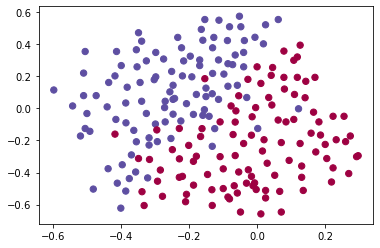

In [21]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

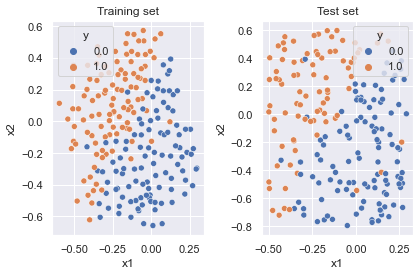

In [22]:
df_train, df_test = load_2D_dataset_pandas(train_X, train_Y, test_X, test_Y)

Epoch 0/50000 : ===Cost=== : 0.693057685581083
⚠️ Probably, there is a mistake in the backward propagation! difference = 0.12322909186805232
Epoch 1000/50000 : ===Cost=== : 0.5758573764207535
⚠️ Probably, there is a mistake in the backward propagation! difference = 0.624554144783303
Epoch 2000/50000 : ===Cost=== : 0.44649376989137324
⚠️ Probably, there is a mistake in the backward propagation! difference = 0.2805080932883796
Epoch 3000/50000 : ===Cost=== : 0.4548752571719582
⚠️ Probably, there is a mistake in the backward propagation! difference = 0.5163685730343218
Epoch 4000/50000 : ===Cost=== : 0.48058282977142364
⚠️ Probably, there is a mistake in the backward propagation! difference = 0.8806792756136794
Epoch 5000/50000 : ===Cost=== : 0.4556027948658804
⚠️ Probably, there is a mistake in the backward propagation! difference = 0.8187581248145566
Epoch 6000/50000 : ===Cost=== : 0.4166216503589998
⚠️ Probably, there is a mistake in the backward propagation! difference = 0.74714908310

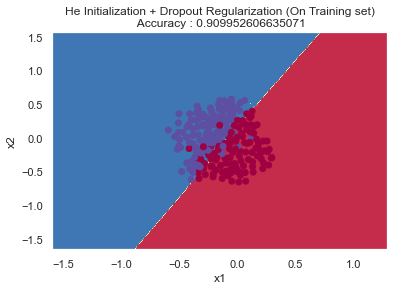

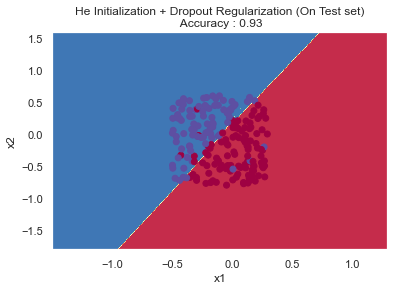

0.93

In [33]:
# Training

## NEVER USE GRADCHECK ON DROPOUT, OTHERWISE

X = df_train[['x1','x2']]
Y = df_train[['y']]

keep_prob_sequence = (1,0.7,0.9,1,1,1)

model = Binary_Deep_L_Layer(hyperparam)
model.compiles(initialization='He',regularization='dropout',keep_prob_sequence= keep_prob_sequence )
model.fit(X,Y,Epochs=50000,grad_check=True)

binary_accuracy(X,Y,model,title='He Initialization + Dropout Regularization (On Training set)')

# Test
test_X = df_test[['x1','x2']]
test_Y = df_test[['y']]
binary_accuracy(test_X,test_Y,model,title='He Initialization + Dropout Regularization (On Test set)')

Epoch 0/50000 : ===Cost=== : 0.7021986726869266
Your backward propagation works perfectly fine! difference = 1.193002763924766e-08
Epoch 1000/50000 : ===Cost=== : 0.25005765055369633
Your backward propagation works perfectly fine! difference = 1.4320312715158712e-08
Epoch 2000/50000 : ===Cost=== : 0.23962237349398113
Your backward propagation works perfectly fine! difference = 1.121655541412745e-07
Epoch 3000/50000 : ===Cost=== : 0.23717895982705925
Your backward propagation works perfectly fine! difference = 1.1629052939587533e-07
Epoch 4000/50000 : ===Cost=== : 0.23517059653204006
Your backward propagation works perfectly fine! difference = 9.562736623287191e-08
Epoch 5000/50000 : ===Cost=== : 0.23345836289304778
Your backward propagation works perfectly fine! difference = 4.037539589659715e-08
Epoch 6000/50000 : ===Cost=== : 0.23207362828261274
Your backward propagation works perfectly fine! difference = 9.556437580511914e-08
Epoch 7000/50000 : ===Cost=== : 0.2309379089496179
Your b

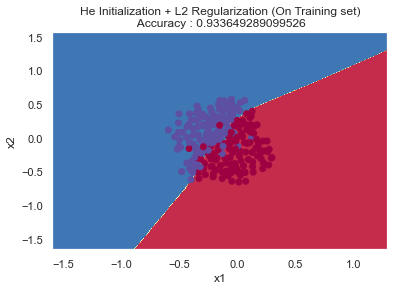

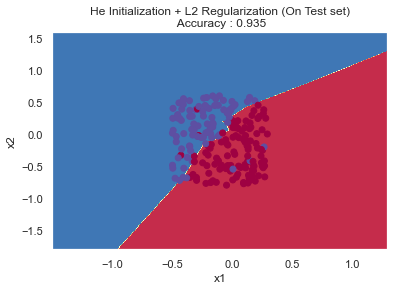

0.935

In [26]:
# Training
X = df_train[['x1','x2']]
Y = df_train[['y']]

lambd = 0.1

model = Binary_Deep_L_Layer(hyperparam)
model.compiles(initialization='He',regularization='L2',lambd= lambd )
model.fit(X,Y,Epochs=50000,grad_check=True)

binary_accuracy(X,Y,model,title='He Initialization + L2 Regularization (On Training set)')

# Test
test_X = df_test[['x1','x2']]
test_Y = df_test[['y']]
binary_accuracy(test_X,test_Y,model,title='He Initialization + L2 Regularization (On Test set)')

Epoch 0/50000 : ===Cost=== : 0.6926056712376526
✔️ Your backward propagation works perfectly fine! difference = 2.007437863375982e-08
Epoch 1000/50000 : ===Cost=== : 0.3049378192635964
✔️ Your backward propagation works perfectly fine! difference = 5.290569825862726e-09
Epoch 2000/50000 : ===Cost=== : 0.226917777137361
✔️ Your backward propagation works perfectly fine! difference = 5.029013773329381e-08
Epoch 3000/50000 : ===Cost=== : 0.22550294505499818
✔️ Your backward propagation works perfectly fine! difference = 1.499993584247751e-07
Epoch 4000/50000 : ===Cost=== : 0.2248290428254081
✔️ Your backward propagation works perfectly fine! difference = 1.7145501585992712e-07
Epoch 5000/50000 : ===Cost=== : 0.22424693890192443
✔️ Your backward propagation works perfectly fine! difference = 1.956378760543274e-07
Epoch 6000/50000 : ===Cost=== : 0.2236950607518633
✔️ Your backward propagation works perfectly fine! difference = 1.8501095496273204e-07
Epoch 7000/50000 : ===Cost=== : 0.2231892

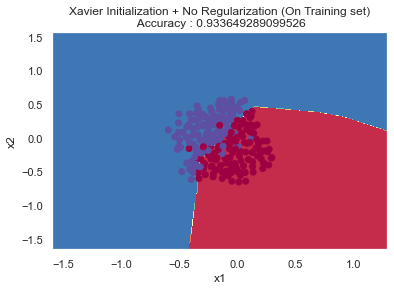

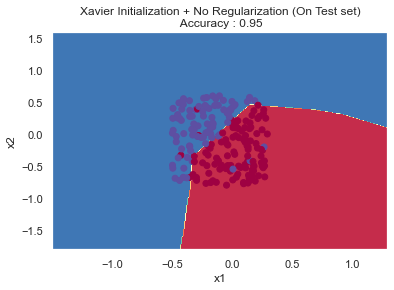

0.95

In [30]:
# Training
X = df_train[['x1','x2']]
Y = df_train[['y']]

model = Binary_Deep_L_Layer(hyperparam)
model.compiles(initialization='Xavier')
model.fit(X,Y,Epochs=50000,grad_check=True)

binary_accuracy(X,Y,model,title='Xavier Initialization + No Regularization (On Training set)')

# Test
test_X = df_test[['x1','x2']]
test_Y = df_test[['y']]
binary_accuracy(test_X,test_Y,model,title='Xavier Initialization + No Regularization (On Test set)')

Epoch 0/50000 : ===Cost=== : 0.6932676577654637
✔️ Your backward propagation works perfectly fine! difference = 1.193002763924766e-08
Epoch 1000/50000 : ===Cost=== : 0.2392085334533585
✔️ Your backward propagation works perfectly fine! difference = 1.5615238379976718e-08
Epoch 2000/50000 : ===Cost=== : 0.2286252215973704
✔️ Your backward propagation works perfectly fine! difference = 8.762533407459175e-08
Epoch 3000/50000 : ===Cost=== : 0.22626732019801205
✔️ Your backward propagation works perfectly fine! difference = 1.2180332157933138e-07
Epoch 4000/50000 : ===Cost=== : 0.22427502503190255
✔️ Your backward propagation works perfectly fine! difference = 7.686332750179464e-08
Epoch 5000/50000 : ===Cost=== : 0.2223858322698743
✔️ Your backward propagation works perfectly fine! difference = 9.193996033163852e-08
Epoch 6000/50000 : ===Cost=== : 0.22092029587376855
✔️ Your backward propagation works perfectly fine! difference = 3.356007402779968e-08
Epoch 7000/50000 : ===Cost=== : 0.21981

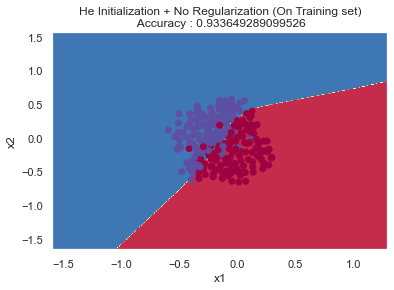

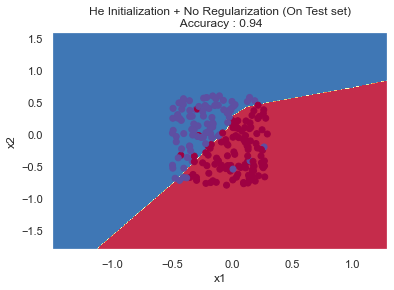

0.94

In [34]:
# Training
X = df_train[['x1','x2']]
Y = df_train[['y']]

model = Binary_Deep_L_Layer(hyperparam)
model.compiles(initialization='He')
model.fit(X,Y,Epochs=50000,grad_check=True)

binary_accuracy(X,Y,model,title='He Initialization + No Regularization (On Training set)')

# Test
test_X = df_test[['x1','x2']]
test_Y = df_test[['y']]
binary_accuracy(test_X,test_Y,model,title='He Initialization + No Regularization (On Test set)')